c:\Users\ANAS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
39852/39852 ━━━━━━━━━━━━━━━━━━━━ 385s 10ms/step - loss: 6.9827e-04 - val_loss: 2.8815e-06
Epoch 2/50
39852/39852 ━━━━━━━━━━━━━━━━━━━━ 362s 9ms/step - loss: 2.1015e-06 - val_loss: 2.9363e-06
Epoch 3/50
39852/39852 ━━━━━━━━━━━━━━━━━━━━ 352s 9ms/step - loss: 1.2142e-06 - val_loss: 2.5220e-06
Epoch 4/50
39852/39852 ━━━━━━━━━━━━━━━━━━━━ 353s 9ms/step - loss: 9.3432e-07 - val_loss: 2.2902e-06
Epoch 5/50
39852/39852 ━━━━━━━━━━━━━━━━━━━━ 370s 9ms/step - loss: 8.5052e-07 - val_loss: 3.4150e-06
Epoch 6/50
39852/39852 ━━━━━━━━━━━━━━━━━━━━ 374s 9ms/step - loss: 7.7803e-07 - val_loss: 1.8523e-06
Epoch 7/50
39852/39852 ━━━━━━━━━━━━━━━━━━━━ 360s 9ms/step - loss: 7.1921e-07 - val_loss: 1.8193e-06
Epoch 8/50
39852/39852 ━━━━━━━━━━━━━━━━━━━━ 380s 10ms/step - loss: 6.9339e-07 - val_loss: 1.4581e-06
Epoch 9/50
39852/39852 ━━━━━━━━━━━━━━━━━━━━ 380s 10ms/step - loss: 6.5748e-07 - val_loss: 1.5967e-06
Epoch 10/50
39852/39852 ━━━━━━━━━━━━━━━━━━━━ 374s 9ms/step - loss: 6.3999e-07 - val_loss: 1.9328e

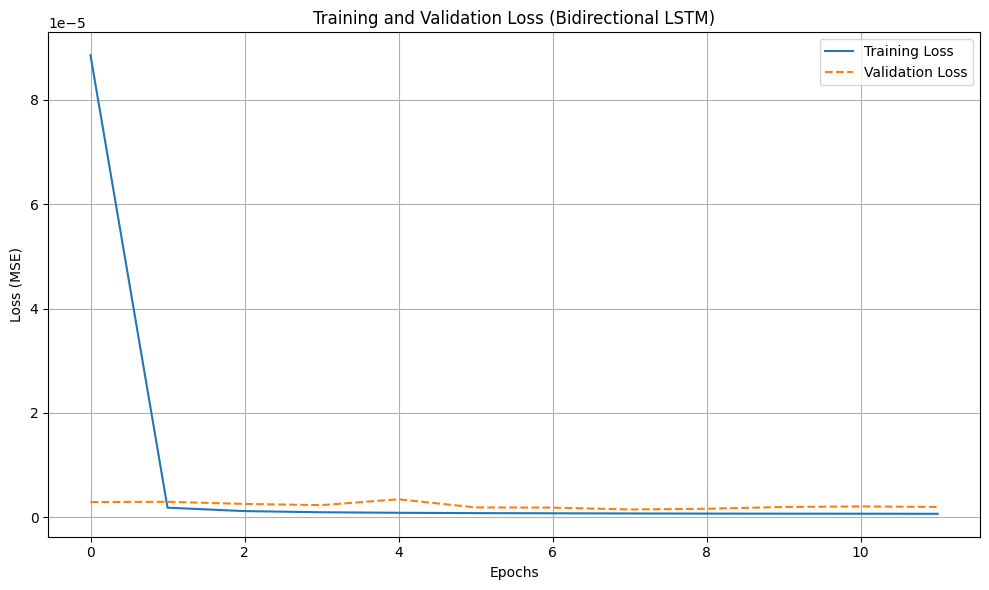

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 1. Load and prepare the data
df = pd.read_csv('ALL_imputed.csv')
# df = df.iloc[:100000].copy()  # If you want only first 100,000 rows
# df = df.iloc[-100000:].copy()  # If you want last 100,000 rows

df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S')
#df.fillna(method='ffill', inplace=True)

# 2. Time-based cyclical features
df['Hour'] = df['Time'].dt.hour
df['Minute'] = df['Time'].dt.minute
df['DayOfWeek'] = df['Time'].dt.dayofweek
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
df['Minute_sin'] = np.sin(2 * np.pi * df['Minute'] / 60)
df['Minute_cos'] = np.cos(2 * np.pi * df['Minute'] / 60)
df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

# 3. Price feature preparation
feature_columns = ['Open_WTI', 'High_WTI', 'Low_WTI', 'Last_WTI', 'Change_WTI', '%Chg_WTI', 'Volume_WTI',
                   'Open_BRENT', 'High_BRENT', 'Low_BRENT', 'Last_BRENT', 'Change_BRENT', '%Chg_BRENT', 'Volume_BRENT',
                   'Open_GAS', 'High_GAS', 'Low_GAS', 'Last_GAS', 'Change_GAS', '%Chg_GAS', 'Volume_GAS']

def convert_percentage_to_float(value):
    if isinstance(value, str) and '%' in value:
        return float(value.replace('%', '')) / 100
    return value

for col in feature_columns:
    df[col] = df[col].apply(convert_percentage_to_float)

df[feature_columns] = df[feature_columns].astype(float)

# 4. Scale and extract PCA factors
price_scaler = MinMaxScaler()
price_scaled = price_scaler.fit_transform(df[feature_columns])

n_factors = 5
pca = PCA(n_components=n_factors)
factors = pca.fit_transform(price_scaled)

# 5. Combine with time features
time_features = df[['Hour_sin', 'Hour_cos', 'Minute_sin', 'Minute_cos', 'DayOfWeek_sin', 'DayOfWeek_cos']].values
combined_features = np.hstack((factors, time_features))

# 6. Prepare targets
target_columns = ['Last_WTI', 'Last_BRENT', 'Last_GAS']
targets = df[target_columns].values
target_scaler = MinMaxScaler()
targets_scaled = target_scaler.fit_transform(targets)

# 7. Sliding window function
def create_sequences(features, targets, times, window_size):
    X_flat, X_seq, y, y_times = [], [], [], []
    for i in range(window_size, len(features)):
        X_seq.append(features[i - window_size:i])                    # For LSTM
        X_flat.append(features[i - window_size:i].flatten())         # For FAVAR
        y.append(targets[i])
        y_times.append(times[i])
    return np.array(X_flat), np.array(X_seq), np.array(y), np.array(y_times)

window_size = 12
X_flat, X_seq, y, y_times = create_sequences(combined_features, targets_scaled, df['Time'].values, window_size)

# 8. Train-test split
split = int(0.8 * len(X_flat))
X_flat_train, X_flat_test = X_flat[:split], X_flat[split:]
X_seq_train, X_seq_test = X_seq[:split], X_seq[split:]
y_train, y_test = y[:split], y[split:]
y_times_test = y_times[split:]

# 9. FAVAR (Linear Regression)
favar_model = LinearRegression()
favar_model.fit(X_flat_train, y_train)
y_pred_favar_scaled = favar_model.predict(X_flat_test)
y_pred_favar = target_scaler.inverse_transform(y_pred_favar_scaled)

# 10. Bidirectional LSTM model
lstm_model = Sequential()
lstm_model.add(Bidirectional(LSTM(units=50, activation='relu'), input_shape=(window_size, X_seq.shape[2])))
lstm_model.add(Dense(3))
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Train model
history = lstm_model.fit(X_seq_train, y_train,
                         epochs=50,
                         batch_size=32,
                         validation_data=(X_seq_test, y_test),
                         callbacks=[early_stop],
                         verbose=1)

# Predict
y_pred_lstm_scaled = lstm_model.predict(X_seq_test)
y_pred_lstm = target_scaler.inverse_transform(y_pred_lstm_scaled)
y_test_actual = target_scaler.inverse_transform(y_test)

# 11. Results DataFrame
results_df = pd.DataFrame({
    'Time': y_times_test,
    'Actual_WTI': y_test_actual[:, 0],
    'FAVAR_WTI': y_pred_favar[:, 0],
    'LSTM_WTI': y_pred_lstm[:, 0],
    'Actual_BRENT': y_test_actual[:, 1],
    'FAVAR_BRENT': y_pred_favar[:, 1],
    'LSTM_BRENT': y_pred_lstm[:, 1],
    'Actual_GAS': y_test_actual[:, 2],
    'FAVAR_GAS': y_pred_favar[:, 2],
    'LSTM_GAS': y_pred_lstm[:, 2],
})

# 12. Evaluation
for i, name in enumerate(['WTI', 'BRENT', 'GAS']):
    favar_mae = mean_absolute_error(y_test_actual[:, i], y_pred_favar[:, i])
    favar_rmse = np.sqrt(mean_squared_error(y_test_actual[:, i], y_pred_favar[:, i]))
    lstm_mae = mean_absolute_error(y_test_actual[:, i], y_pred_lstm[:, i])
    lstm_rmse = np.sqrt(mean_squared_error(y_test_actual[:, i], y_pred_lstm[:, i]))
    print(f"{name} - FAVAR MAE: {favar_mae:.4f}, RMSE: {favar_rmse:.4f} | LSTM MAE: {lstm_mae:.4f}, RMSE: {lstm_rmse:.4f}")

# 13. Plot predictions
for i, name in enumerate(['WTI', 'BRENT', 'GAS']):
    plt.figure(figsize=(15, 5))
    plt.plot(results_df['Time'], results_df[f'Actual_{name}'], label='Actual')
    plt.plot(results_df['Time'], results_df[f'FAVAR_{name}'], label='FAVAR', linestyle='--')
    plt.plot(results_df['Time'], results_df[f'LSTM_{name}'], label='LSTM', linestyle=':')
    plt.title(f'{name} Price Prediction (Full Test Set)')
    plt.xlabel('Datetime')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'{name}_comparison_favar_bidirectional_lstm.png')
    plt.close()

# 14. Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Training and Validation Loss (Bidirectional LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('training_validation_loss_bidirectional_lstm.png')
plt.show()


In [3]:
# 13. Plot predictions
for i, name in enumerate(['WTI', 'BRENT', 'GAS']):
    plt.figure(figsize=(15, 5))
    plt.plot(results_df['Time'][-200:], results_df[f'Actual_{name}'][-200:], label='Actual')
    plt.plot(results_df['Time'][-200:], results_df[f'FAVAR_{name}'][-200:], label='FAVAR', linestyle='--')
    plt.plot(results_df['Time'][-200:], results_df[f'LSTM_{name}'][-200:], label='LSTM', linestyle=':')
    plt.title(f'{name} Price Prediction (last 200)')
    plt.xlabel('Datetime')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'{name}_comparison_favar_bidirectional_lstm_last200.png')
    plt.close()

In [4]:
# 13. Plot predictions
for i, name in enumerate(['WTI', 'BRENT', 'GAS']):
    plt.figure(figsize=(15, 5))
    plt.plot(results_df['Time'][-24:], results_df[f'Actual_{name}'][-24:], label='Actual')
    plt.plot(results_df['Time'][-24:], results_df[f'FAVAR_{name}'][-24:], label='FAVAR', linestyle='--')
    plt.plot(results_df['Time'][-24:], results_df[f'LSTM_{name}'][-24:], label='LSTM', linestyle=':')
    plt.title(f'{name} Price Prediction (last 2 hours )')
    plt.xlabel('Datetime')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'{name}_comparison_favar_bidirectional_lstm_last24.png')
    plt.close()

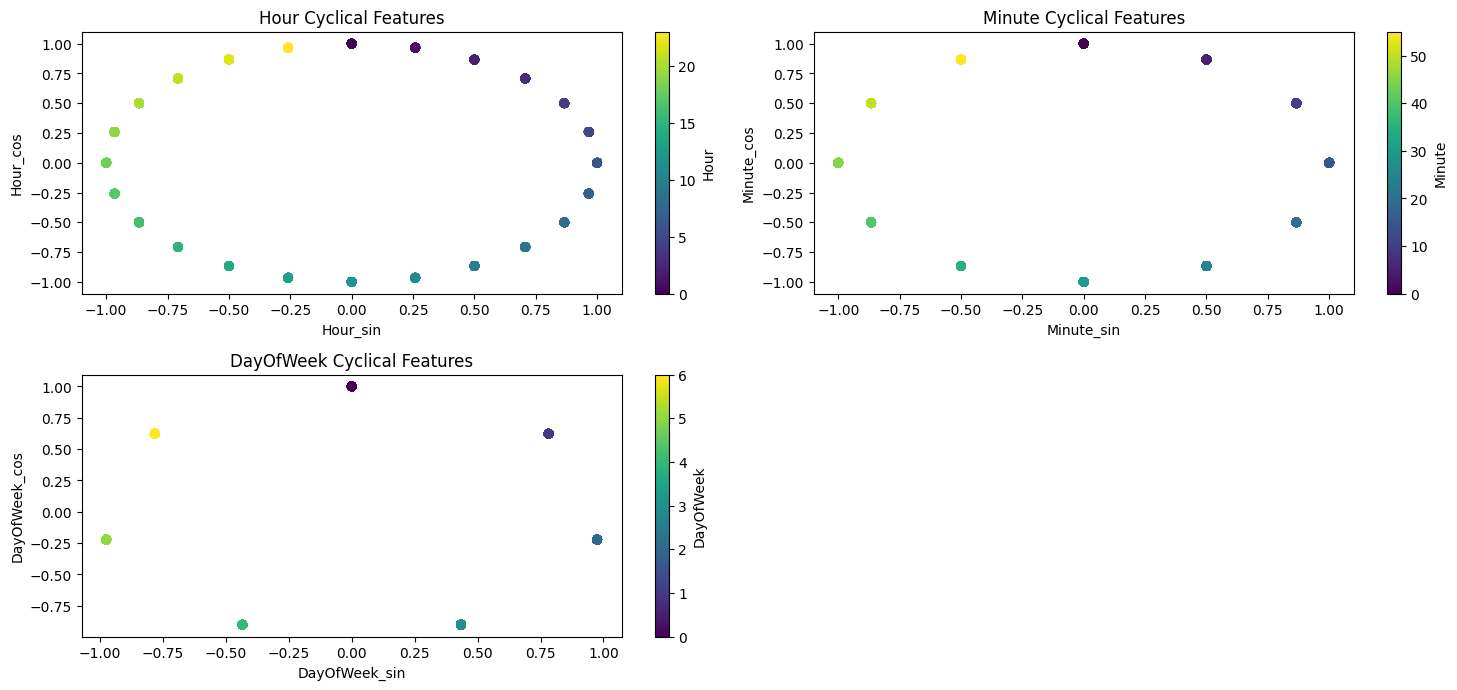

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create sample data
hours = np.arange(0, 24, 1)
minutes = np.arange(0, 60, 5)
days = np.arange(0, 7, 1)

# Create DataFrame
df = pd.DataFrame({
    'Hour': np.repeat(hours, len(minutes) * len(days)),
    'Minute': np.tile(np.repeat(minutes, len(days)), len(hours)),
    'DayOfWeek': np.tile(days, len(hours) * len(minutes))
})

# Calculate cyclical features
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
df['Minute_sin'] = np.sin(2 * np.pi * df['Minute'] / 60)
df['Minute_cos'] = np.cos(2 * np.pi * df['Minute'] / 60)
df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

# Plotting
plt.figure(figsize=(15, 10))

# Hour plot
plt.subplot(3, 2, 1)
plt.scatter(df['Hour_sin'], df['Hour_cos'], c=df['Hour'], cmap='viridis')
plt.title('Hour Cyclical Features')
plt.xlabel('Hour_sin')
plt.ylabel('Hour_cos')
plt.colorbar(label='Hour')

# Minute plot
plt.subplot(3, 2, 2)
plt.scatter(df['Minute_sin'], df['Minute_cos'], c=df['Minute'], cmap='viridis')
plt.title('Minute Cyclical Features')
plt.xlabel('Minute_sin')
plt.ylabel('Minute_cos')
plt.colorbar(label='Minute')

# DayOfWeek plot
plt.subplot(3, 2, 3)
plt.scatter(df['DayOfWeek_sin'], df['DayOfWeek_cos'], c=df['DayOfWeek'], cmap='viridis')
plt.title('DayOfWeek Cyclical Features')
plt.xlabel('DayOfWeek_sin')
plt.ylabel('DayOfWeek_cos')
plt.colorbar(label='DayOfWeek')

plt.tight_layout()
plt.savefig('cyclical_features.png')

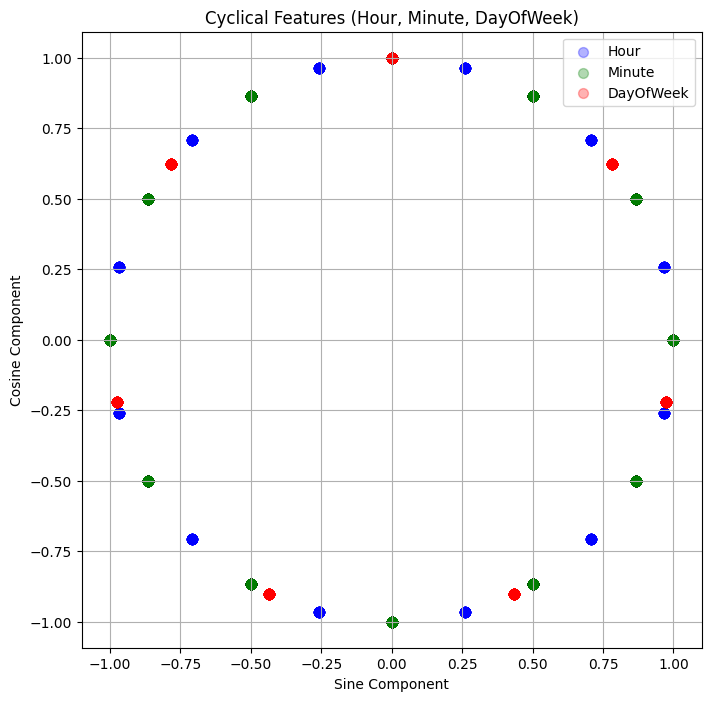

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create sample data
hours = np.arange(0, 24, 1)
minutes = np.arange(0, 60, 5)
days = np.arange(0, 7, 1)

# Create DataFrame
df = pd.DataFrame({
    'Hour': np.repeat(hours, len(minutes) * len(days)),
    'Minute': np.tile(np.repeat(minutes, len(days)), len(hours)),
    'DayOfWeek': np.tile(days, len(hours) * len(minutes))
})

# Calculate cyclical features
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
df['Minute_sin'] = np.sin(2 * np.pi * df['Minute'] / 60)
df['Minute_cos'] = np.cos(2 * np.pi * df['Minute'] / 60)
df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

# Plotting
plt.figure(figsize=(8, 8))

# Plot all features on the same graph
plt.scatter(df['Hour_sin'], df['Hour_cos'], c='blue', label='Hour', alpha=0.3, s=50)
plt.scatter(df['Minute_sin'], df['Minute_cos'], c='green', label='Minute', alpha=0.3, s=50)
plt.scatter(df['DayOfWeek_sin'], df['DayOfWeek_cos'], c='red', label='DayOfWeek', alpha=0.3, s=50)

plt.title('Cyclical Features (Hour, Minute, DayOfWeek)')
plt.xlabel('Sine Component')
plt.ylabel('Cosine Component')
plt.legend()
plt.grid(True)
plt.axis('equal')  # Ensure circular appearance

plt.savefig('cyclical_features_combined.png')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create sample data
hours = np.arange(0, 24, 1)
minutes = np.arange(0, 60, 5)
days = np.arange(0, 7, 1)

# Create DataFrame
df = pd.DataFrame({
    'Hour': np.repeat(hours, len(minutes) * len(days)),
    'Minute': np.tile(np.repeat(minutes, len(days)), len(hours)),
    'DayOfWeek': np.tile(days, len(hours) * len(minutes))
})

# Calculate cyclical features
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
df['Minute_sin'] = np.sin(2 * np.pi * df['Minute'] / 60)
df['Minute_cos'] = np.cos(2 * np.pi * df['Minute'] / 60)
df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

# Plotting each feature in a separate figure
# Hour plot
plt.figure(figsize=(10, 10))
plt.scatter(df['Hour_sin'], df['Hour_cos'], c=df['Hour'], cmap='viridis', s=100)
plt.title('Hour Cyclical Features', fontsize=16)
plt.xlabel('Hour_sin', fontsize=12)
plt.ylabel('Hour_cos', fontsize=12)
plt.colorbar(label='Hour')
plt.grid(True)
plt.axis('equal')
plt.savefig('hour_cyclical_features.png')
plt.close()

# Minute plot
plt.figure(figsize=(10, 10))
plt.scatter(df['Minute_sin'], df['Minute_cos'], c=df['Minute'], cmap='viridis', s=100)
plt.title('Minute Cyclical Features', fontsize=16)
plt.xlabel('Minute_sin', fontsize=12)
plt.ylabel('Minute_cos', fontsize=12)
plt.colorbar(label='Minute')
plt.grid(True)
plt.axis('equal')
plt.savefig('minute_cyclical_features.png')
plt.close()

# DayOfWeek plot
plt.figure(figsize=(10, 10))
plt.scatter(df['DayOfWeek_sin'], df['DayOfWeek_cos'], c=df['DayOfWeek'], cmap='viridis', s=100)
plt.title('DayOfWeek Cyclical Features', fontsize=16)
plt.xlabel('DayOfWeek_sin', fontsize=12)
plt.ylabel('DayOfWeek_cos', fontsize=12)
plt.colorbar(label='DayOfWeek')
plt.grid(True)
plt.axis('equal')
plt.savefig('dayofweek_cyclical_features.png')
plt.close()

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create sample data with finer granularity for smoother curves
hours = np.linspace(0, 24, 100)  # 100 points over 24 hours
minutes = np.linspace(0, 60, 100)  # 100 points over 60 minutes
days = np.linspace(0, 7, 100)  # 100 points over 7 days

# Create DataFrames for each feature
df_hour = pd.DataFrame({'Hour': hours})
df_minute = pd.DataFrame({'Minute': minutes})
df_day = pd.DataFrame({'DayOfWeek': days})

# Calculate cyclical features
df_hour['Hour_sin'] = np.sin(2 * np.pi * df_hour['Hour'] / 24)
df_hour['Hour_cos'] = np.cos(2 * np.pi * df_hour['Hour'] / 24)
df_minute['Minute_sin'] = np.sin(2 * np.pi * df_minute['Minute'] / 60)
df_minute['Minute_cos'] = np.cos(2 * np.pi * df_minute['Minute'] / 60)
df_day['DayOfWeek_sin'] = np.sin(2 * np.pi * df_day['DayOfWeek'] / 7)
df_day['DayOfWeek_cos'] = np.cos(2 * np.pi * df_day['DayOfWeek'] / 7)

# Plotting each feature in a separate figure
# Hour plot
plt.figure(figsize=(12, 6))
plt.plot(df_hour['Hour'], df_hour['Hour_sin'], label='Hour_sin', color='blue')
plt.plot(df_hour['Hour'], df_hour['Hour_cos'], label='Hour_cos', color='red', linestyle='--')
plt.title('Hour Cyclical Features Over 24-Hour Cycle', fontsize=16)
plt.xlabel('Hour', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.savefig('hour_cyclical_timeline.png')
plt.close()

# Minute plot
plt.figure(figsize=(12, 6))
plt.plot(df_minute['Minute'], df_minute['Minute_sin'], label='Minute_sin', color='blue')
plt.plot(df_minute['Minute'], df_minute['Minute_cos'], label='Minute_cos', color='red', linestyle='--')
plt.title('Minute Cyclical Features Over 60-Minute Cycle', fontsize=16)
plt.xlabel('Minute', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.savefig('minute_cyclical_timeline.png')
plt.close()

# DayOfWeek plot
plt.figure(figsize=(12, 6))
plt.plot(df_day['DayOfWeek'], df_day['DayOfWeek_sin'], label='DayOfWeek_sin', color='blue')
plt.plot(df_day['DayOfWeek'], df_day['DayOfWeek_cos'], label='DayOfWeek_cos', color='red', linestyle='--')
plt.title('DayOfWeek Cyclical Features Over 7-Day Cycle', fontsize=16)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.savefig('dayofweek_cyclical_timeline.png')
plt.close()

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create timeline for one week (7 days = 168 hours)
hours_in_week = 168
time_hours = np.linspace(0, hours_in_week, 1000)  # 1000 points for smooth curves

# Create DataFrame
df = pd.DataFrame({
    'Time_Hours': time_hours,
    'Hour': time_hours % 24,  # Hour cycles every 24 hours
    'Minute': (time_hours * 60) % 60,  # Minute cycles every 60 minutes (convert hours to minutes)
    'DayOfWeek': time_hours / 24 % 7  # DayOfWeek cycles every 7 days
})

# Calculate cyclical features
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
df['Minute_sin'] = np.sin(2 * np.pi * df['Minute'] / 60)
df['Minute_cos'] = np.cos(2 * np.pi * df['Minute'] / 60)
df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

# Plotting all features in a single figure
plt.figure(figsize=(13, 4))

# Minute plots (168 cycles, use lower alpha to reduce visual clutter)
plt.plot(df['Time_Hours'], df['Minute_sin'], label='Minute_sin', color='green', linewidth=1, alpha=0.3)
plt.plot(df['Time_Hours'], df['Minute_cos'], label='Minute_cos', color='green', linestyle='--', linewidth=1, alpha=0.3)

# Hour plots (7 cycles over 168 hours)
plt.plot(df['Time_Hours'], df['Hour_sin'], label='Hour_sin', color='blue', linewidth=1.5)
plt.plot(df['Time_Hours'], df['Hour_cos'], label='Hour_cos', color='blue', linestyle='--', linewidth=1.5)

# DayOfWeek plots (1 cycle over 7 days)
plt.plot(df['Time_Hours'], df['DayOfWeek_sin'], label='DayOfWeek_sin', color='red', linewidth=2)
plt.plot(df['Time_Hours'], df['DayOfWeek_cos'], label='DayOfWeek_cos', color='red', linestyle='--', linewidth=2)

plt.title('Cyclical Features Over One-Week Timeline', fontsize=16)
plt.xlabel('Time (Hours)', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(fontsize=10, loc='upper right')
plt.grid(True)

plt.savefig('cyclical_features_one_week_timeline.png')
plt.close()

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

# 1. Load the data
df = pd.read_csv('ALL_cleaned_imputed.csv')

# 2. Define target columns
target_columns = ['Last_WTI', 'Last_BRENT', 'Last_GAS']

# 3. Convert to float and handle percentage or invalid values
def convert_to_float(value):
    try:
        if isinstance(value, str) and '%' in value:
            return float(value.replace('%', '')) / 100
        return float(value)
    except (ValueError, TypeError):
        return np.nan

for col in target_columns:
    df[col] = df[col].apply(convert_to_float)
    df[col] = df[col].astype(float)

# 4. Extract raw data
raw_data = df[target_columns].dropna().values

# 5. Apply MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(raw_data)

# 6. Create a figure for histograms
plt.figure(figsize=(15, 10))

for i, col in enumerate(target_columns):
    # Raw data histogram
    plt.subplot(3, 2, 2 * i + 1)
    sns.histplot(raw_data[:, i], bins=50, kde=True, color='blue')
    plt.title(f'{col} (Raw) Distribution')
    plt.xlabel('Price')
    plt.ylabel('Count')

    # Scaled data histogram
    plt.subplot(3, 2, 2 * i + 2)
    sns.histplot(scaled_data[:, i], bins=50, kde=True, color='green')
    plt.title(f'{col} (Scaled) Distribution')
    plt.xlabel('Scaled Price')
    plt.ylabel('Count')

plt.tight_layout()
plt.savefig('price_histograms_raw_vs_scaled.png')
plt.close()

# 7. Create a figure for boxplots
plt.figure(figsize=(12, 8))

# Raw data boxplot
plt.subplot(1, 2, 1)
sns.boxplot(data=df[target_columns], palette='Blues')
plt.title('Raw Data Boxplot')
plt.ylabel('Price')

# Scaled data boxplot
plt.subplot(1, 2, 2)
scaled_df = pd.DataFrame(scaled_data, columns=target_columns)
sns.boxplot(data=scaled_df, palette='Greens')
plt.title('Scaled Data Boxplot')
plt.ylabel('Scaled Price')

plt.tight_layout()
plt.savefig('price_boxplots_raw_vs_scaled.png')
plt.close()

print("Visualizations saved as 'price_histograms_raw_vs_scaled.png' and 'price_boxplots_raw_vs_scaled.png'")

Visualizations saved as 'price_histograms_raw_vs_scaled.png' and 'price_boxplots_raw_vs_scaled.png'


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# 1. Load the data
df = pd.read_csv('ALL_imputed.csv')

# 2. Define feature columns
feature_columns = [
    'Open_WTI', 'High_WTI', 'Low_WTI', 'Last_WTI', 'Change_WTI', '%Chg_WTI', 'Volume_WTI',
    'Open_BRENT', 'High_BRENT', 'Low_BRENT', 'Last_BRENT', 'Change_BRENT', '%Chg_BRENT', 'Volume_BRENT',
    'Open_GAS', 'High_GAS', 'Low_GAS', 'Last_GAS', 'Change_GAS', '%Chg_GAS', 'Volume_GAS'
]

# Group columns by commodity
wti_columns = [col for col in feature_columns if 'WTI' in col]
brent_columns = [col for col in feature_columns if 'BRENT' in col]
gas_columns = [col for col in feature_columns if 'GAS' in col]

# 3. Convert to float and handle percentage or invalid values
def convert_to_float(value):
    try:
        if isinstance(value, str) and '%' in value:
            return float(value.replace('%', '')) / 100
        return float(value)
    except (ValueError, TypeError):
        return np.nan

for col in feature_columns:
    df[col] = df[col].apply(convert_to_float)
    df[col] = df[col].astype(float)

# 4. Drop NaN values for visualization
df_clean = df[feature_columns].dropna()

# 5. Apply MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_clean)
scaled_df = pd.DataFrame(scaled_data, columns=feature_columns)

# 6. Function to plot boxplots for a group of columns
def plot_boxplots(columns, commodity_name, raw_data, scaled_data):
    plt.figure(figsize=(15, 8))

    # Raw data boxplot
    plt.subplot(1, 2, 1)
    sns.boxplot(data=raw_data[columns], palette='Blues')
    plt.title(f'{commodity_name} Features (Raw)')
    plt.ylabel('Value')
    plt.xticks(rotation=45)

    # Scaled data boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(data=scaled_data[columns], palette='Greens')
    plt.title(f'{commodity_name} Features (Scaled)')
    plt.ylabel('Scaled Value')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.savefig(f'{commodity_name.lower()}_features_boxplots_raw_vs_scaled.png')
    plt.close()

# 7. Plot boxplots for each commodity
plot_boxplots(wti_columns, 'WTI', df_clean, scaled_df)
plot_boxplots(brent_columns, 'BRENT', df_clean, scaled_df)
plot_boxplots(gas_columns, 'GAS', df_clean, scaled_df)

print("Boxplots saved as 'wti_features_boxplots_raw_vs_scaled.png', "
      "'brent_features_boxplots_raw_vs_scaled.png', and 'gas_features_boxplots_raw_vs_scaled.png'")

Boxplots saved as 'wti_features_boxplots_raw_vs_scaled.png', 'brent_features_boxplots_raw_vs_scaled.png', and 'gas_features_boxplots_raw_vs_scaled.png'
